In [2]:
import torch
import torchvision
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU')
else: 
  device = torch.device('cpu')
  print('cpu')

GPU


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    
import random
import gzip
import math
import functools
import os

from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics, neighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from skimage import exposure
from skimage import feature


In [4]:
n_epochs = 4
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

#'DataLoader' object has no attribute 'shape'
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [22]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data=example_data.to(device=device)
example_targets= example_targets.to(device=device)


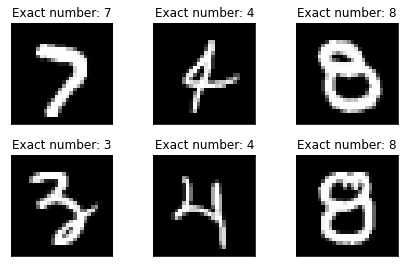

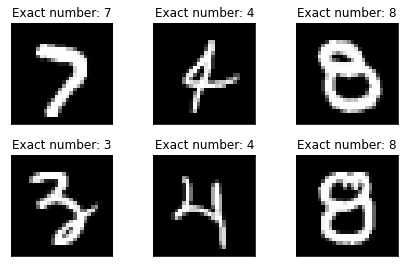

In [24]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data.cpu()[i][0], cmap='gray', interpolation='none')
  plt.title("Exact number: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Building a network

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)  
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)       #you don't know how many rows you want but are sure of the number of columns,
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
network = Net().to(device=device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    target = target.to(device=device)
    data = data.to(device=device)
    optimizer.zero_grad()  
    output = network(data)   
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      target = target.to(device=device)
      data = data.to(device=device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Train the model and run on test set

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326960
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.306949
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.280513
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.270255
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.250465
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.237874
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.221746
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.184109
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.187201
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.083960
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.932725
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.697922
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.672135
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.538925
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.523081
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.554050
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.271878
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.281574
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.210876
Train Epoch: 

Compare train and test Loss

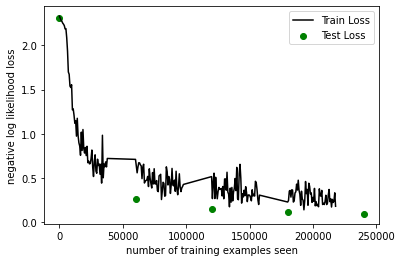

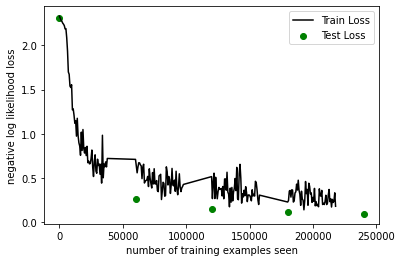

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='black')
plt.scatter(test_counter, test_losses, color='green')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

Check how model can predict example

In [26]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


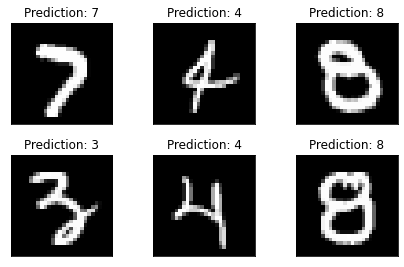

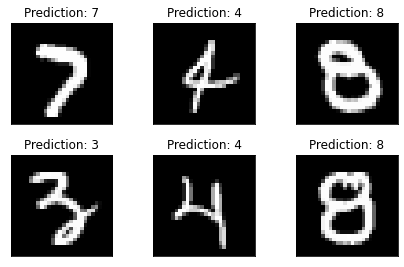

In [27]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data.cpu()[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig